# Main functions used in experiments

In [1]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Environment: Windy gridworld
Gives a reward of -1 for each step taken, while the final state is not reached

In [2]:
# from windy_gridworld import WindyGridworldEnv
from gridworld import GridworldEnv
# env = WindyGridworldEnv()
env = GridworldEnv()
# env??
import gym
# env = gym.envs.make("FrozenLake-v0")
# env.env.__init__(is_slippery=False)

In [3]:
try:
    env.nA = env.env.nA
    env.nS = env.env.nS
except:
    pass

## Policy

### Target policy (choose greedy vs non-greedy)
Greedy policy 

In [4]:
class GreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q):
        self.Q = Q
    
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a greedy policy
        """   
        # for state and action only:
        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        if action in max_indices:
            prob = 1/len(max_indices)
        else:
            prob = 0
        
        return prob
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """

        best_actions = [i for i, j in enumerate([self.Q[obs][i] for i in range(4)]) 
                   if j == max([self.Q[obs][i] for i in range(4)])] 

        best_action = np.random.choice(best_actions)
        
        return best_action

In [5]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
        
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a epsilon greedy policy
        """

        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        # all probs are equal, give all equal probabilities
        if len(max_indices) == len(action_probs):
            return 1/len(max_indices)
            
        if action in max_indices:
            prob = (1-self.epsilon)/len(max_indices)
        else:
            prob = epsilon / (len(action_probs) - len(max_indices))
        
        return prob
    

    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
         
        best_actions = [i for i, j in enumerate(self.Q[obs])
                   if j == np.max(self.Q[obs])] 

        p = np.random.uniform()
        if p > self.epsilon:
            # choose one of the best actions
            action = np.random.choice(best_actions)
        else:
            action = np.random.randint(0,4)
                
        return action


# Monte Carlo

In [30]:
def sample_episode(env, policy, evaluation=False):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length. 
        state after the termination is not included in the list of states.
    """
    # initialize
    states = []
    actions = []
    rewards = []
    dones = []
    
    # get a starting state
    s = env.reset()
    d = False
    
    # keep looping until done, don's save the terminal state
    while not d:
        states.append(s)
        a = policy.sample_action(s)
        s, r, d, _ = env.step(a)
        
        # save                
        actions.append(a)
        rewards.append(r)
        dones.append(d)
        
        if evaluation and len(states) > (policy.Q.shape[0] + 1):
            return len(states)
    
    if evaluation:
        return len(states)
    else:
        return states, actions, rewards, dones

In [33]:
# check the length of episodes that are generated for eps greedy policy
Q = np.zeros((env.nS, env.nA))
bp = EpsilonGreedyPolicy(Q, epsilon=0.1)

for episode in range(1):
    trajectory_data = sample_episode(env, bp)
    print(f"length of episode {episode}: {len(trajectory_data[0])}")

length of episode 0: 244


## Importance Sampling


In [34]:
def mc_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, discount_factor=1.0,
                           sampling_function=sample_episode, epsilon=0.05, seed=42, 
                           analyse_states=[(0,2), (0,1), (10,2), (2,1), (4,2)]):
    """
    Monte Carlo prediction algorithm. Calculates the Q function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI gym environment.
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        num_episodes: Number of episodes to sample.
        weighted: Boolean flag to use weighted or ordinary importance sampling.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from (state, action) -> value.
    """

    # set the current Q to a large negative value
    Q = np.zeros((env.nS, env.nA))
    if weighted:
        C = np.zeros((env.nS, env.nA))
    else:
        returns_count = defaultdict(lambda: defaultdict(float))
    
    episode_lens = []
    target_episode_lens = []
    # set seed
    np.random.seed(seed)
    
    analysis_values = dict((k,[]) for k in analyse_states)
    
    # sample episodes
    for i in tqdm(range(num_episodes), position=0):
        # update behavioral and target policy
        behavior_policy.Q = Q
        target_policy.Q = Q        
    
        # sample episode with new behavioural function
        states, actions, rewards, dones = sampling_function(env, behavior_policy)
        
        # save the episode length
        episode_lens.append(len(states)) 

        G = 0        
        W = 1
        
        # loop backwards over the trajectory
        for i, timestep in enumerate(range(len(states)-1, -1, -1)):
            s = states[timestep]
            r = rewards[timestep]
            a = actions[timestep]
            G = discount_factor * G + r
            
            if weighted:
                # add W to the sum of weights C
                C[s][a] += W
                Q[s][a] += W/C[s][a] * (G - Q[s][a])
            else:
                returns_count[s][a] += 1 
                # use every visit incremental method
                Q[s][a] += 1/returns_count[s][a] * W * (G - Q[s][a])

            W *= (target_policy.get_probs(s, a)) / (behavior_policy.get_probs(s, a))        

            if W == 0:
                break

        # store state values to analyse
        for (s,a) in analyse_states:
#             print(Q[s][a])
            analysis_values[(s,a)].append(Q[s][a])
    
        # sample from target policy to check performance so far
        target_episode_lens.append(sampling_function(env, target_policy, evaluation=True))
        
    return Q, episode_lens, analysis_values, target_episode_lens

## Performance


In [90]:
# Reproducible
seed = 42

# set other parameters
epsilon = 0.1
gamma = 0.95
num_episodes = 100
Q = np.zeros((env.nS, env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_mc_ordinary, mc_ordinary_epslengths, mc_analysis_ordinary, mc_ordinary_target_lens = mc_importance_sampling(env,
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)

print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_mc_weighted, mc_weighted_epslengths, mc_analysis_weighted, mc_weighted_target_lens = mc_importance_sampling(env,
                                                               behavioral_policy, target_policy,
                                                               num_episodes, weighted=True, discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)


  0%|          | 0/100 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (100 episodes)


100%|██████████| 100/100 [00:00<00:00, 680.95it/s]

Updating Q using weighted importance sampling (100 episodes)


In [91]:
# check how long an episode takes under the found Q function
# mc_greedy_ordinary = GreedyPolicy(Q_mc_ordinary)
mc_greedy_weighted = GreedyPolicy(Q_mc_weighted)

# mc_ordinary_episode = sample_episode(env, mc_greedy_ordinary)
mc_weighted_episode = sample_episode(env, mc_greedy_weighted)

# print(f"resulting episode length ordinary: {len(mc_ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(mc_weighted_episode[0])}")

resulting episode length weighted: 8


In [92]:
from plot_grid import plot_action_value

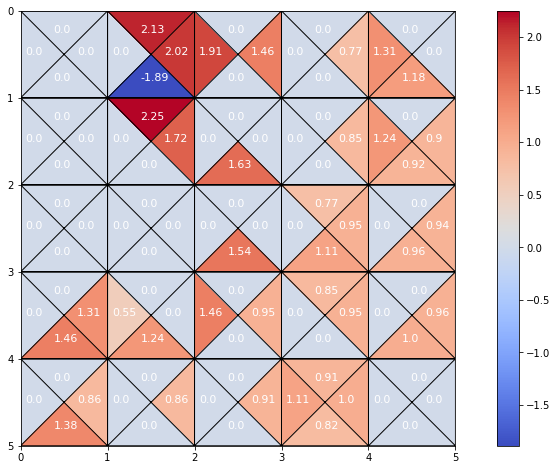

In [93]:
plot_action_value(Q_mc_ordinary)

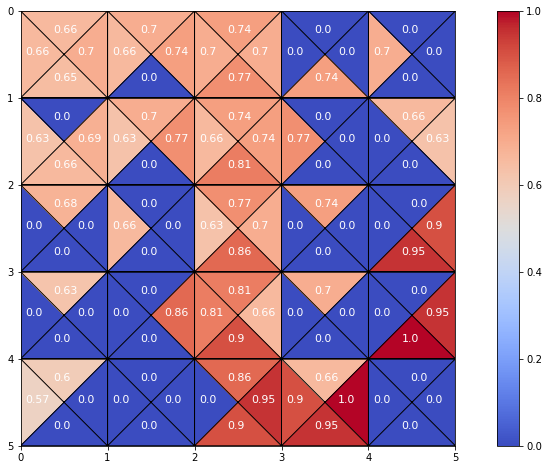

In [94]:
plot_action_value(Q_mc_weighted)

### Plotting episode lengths during training

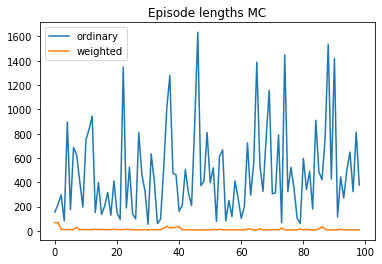

In [79]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

# set smoothing factor
n = 1
# print(mc_weighted_target_lens)
plt.plot(running_mean(mc_ordinary_epslengths, n), label="ordinary")
plt.plot(running_mean(mc_weighted_epslengths, n), label="weighted")
# plt.hlines(num_episodes)
plt.title('Episode lengths MC')
# plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

### Episode lengths using target policy during training

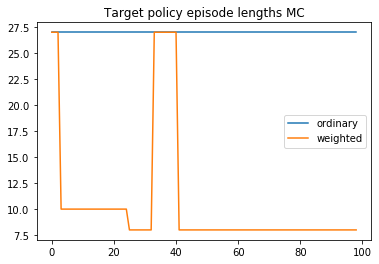

In [78]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

# set smoothing factor
n = 1
# print(mc_weighted_target_lens)
plt.plot(running_mean(mc_ordinary_target_lens, n), label="ordinary")
plt.plot(running_mean(mc_weighted_target_lens, n), label="weighted")
# plt.hlines(num_episodes)
plt.title('Target policy episode lengths MC')
# plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

# Temporal Difference

### TO-DO: TD Ordinary Importance Sampling (make it work for gridworld)
Copied from TD_lab. Currently on-policy, needs to be off-policy.

Confused: do we need value functions instead of q-values? Do we even use importance weights in off-policy TD? Are there more off-policy TD methods besides SARSA?

### TO-DO: TD Weighted Importance Sampling (same as above but weighted)

In [42]:
## TD weighted importance sampling

In [45]:
import math

def sarsa_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, 
                                       discount_factor=1.0, alpha=0.5, seed=42, sampling_function=sample_episode,
                                 analyse_states=[(0,2), (0,1), (14,2), (2,1), (8,2)]):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        target policy: A policy which allows us to sample actions with its sample_action method.
        behaviour policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    np.random.seed(seed)
    
    # Keep track of useful statistics
    stats = []
    target_episode_lens =[]
    
#     Q = np.ones((env.nS, env.nA)) * -100
    Q = np.zeros((env.nS, env.nA))
    C = np.zeros((env.nS, env.nA))
    
    analysis_values = dict((k,[]) for k in analyse_states)
    
    for i_episode in tqdm(range(num_episodes), position=0):
        i = 0
        R = 0
        W = 1
        
        behavior_policy.Q = Q
        target_policy.Q = Q
        
        return_counts = defaultdict(lambda: defaultdict(float))
        
        s = env.reset()
        a = behavior_policy.sample_action(s)
        
        while True:
            # Take action
            s_prime, r, final_state, _ = env.step(a)
            
            # Sample action at from next state
            a_prime = behavior_policy.sample_action(s_prime)                       
            
            W = (target_policy.get_probs(s_prime,a_prime))/(behavior_policy.get_probs(s_prime,a_prime))
            
            if W == 0:
                break
            
            if weighted:
                # Update weight and C
                C[s][a] = W
                # importance weight is 1 
                Q[s][a] += alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])                
            else:
                return_counts[s][a] += 1
                Q[s][a] += W/return_counts[s][a] * alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])                
                
            behavior_policy.Q[s][a] = Q[s][a]
            target_policy.Q[s][a] = Q[s][a]
            
            s = s_prime
            a = a_prime
            
            R += r
            i += 1 
            
            if final_state:
                break
            
        stats.append((i, R))

        # store state values to analyse
        for (s,a) in analyse_states:
            analysis_values[(s,a)].append(Q[s][a])
            
        # sample from target policy to check performance so far
        target_episode_lens.append(sampling_function(env, target_policy, evaluation=True))
        
    episode_lengths, episode_returns = zip(*stats)
    
    return Q, episode_lengths, analysis_values, target_episode_lens

In [80]:
# Reproducible
seed = 42

# set other parameters
epsilon = 0.1
gamma = 0.99
num_episodes = 100
Q = np.zeros((env.nS, env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_sarsa_ordinary, sarsa_ordinary_epslengths, sarsa_analysis_ordinary, sarsa_ordinary_target_episode_lens = sarsa_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,
                                                                         discount_factor=gamma, seed=seed)

Q = np.zeros((env.nS, env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)


print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_sarsa_weighted, sarsa_weighted_epslengths, sarsa_analysis_weighted, sarsa_weighted_target_episode_lens = sarsa_importance_sampling(env, 
                                                                        behavioral_policy, target_policy,
                                                                        num_episodes, weighted=True,
                                                                        discount_factor=gamma, seed=seed)


100%|██████████| 100/100 [00:00<00:00, 644.19it/s]

Updating Q using ordinary importance sampling (100 episodes)
Updating Q using weighted importance sampling (100 episodes)


In [81]:
# check how long an episode takes under the found Q function
sarsa_greedy_ordinary = GreedyPolicy(Q_sarsa_ordinary)
sarsa_greedy_weighted = GreedyPolicy(Q_sarsa_weighted)

sarsa_ordinary_episode = sample_episode(env, sarsa_greedy_ordinary)
sarsa_weighted_episode = sample_episode(env, sarsa_greedy_weighted)

print(f"resulting episode length ordinary: {len(sarsa_ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(sarsa_weighted_episode[0])}")

resulting episode length ordinary: 8
resulting episode length weighted: 8


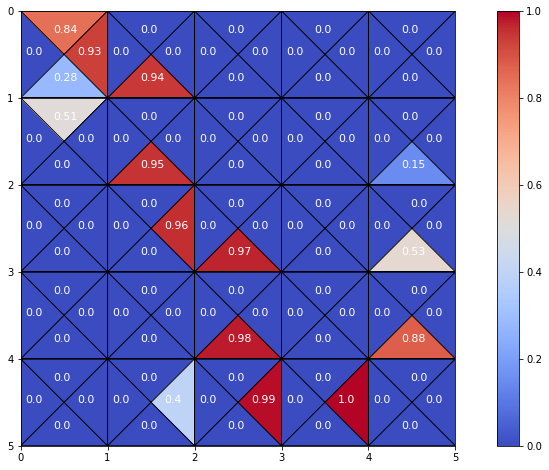

In [82]:
plot_action_value(Q_sarsa_ordinary)

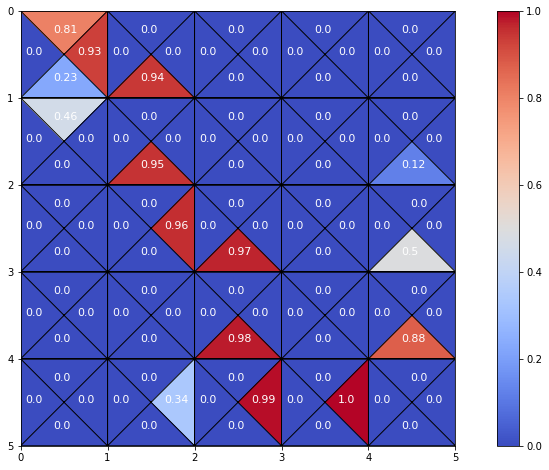

In [83]:
plot_action_value(Q_sarsa_weighted)

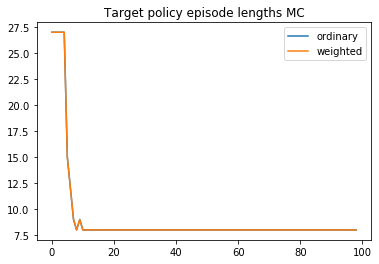

In [84]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

# set smoothing factor
n = 1
# print(mc_weighted_target_lens)
plt.plot(running_mean(sarsa_ordinary_target_episode_lens, n), label="ordinary")
plt.plot(running_mean(sarsa_weighted_target_episode_lens, n), label="weighted")
# plt.hlines(num_episodes)
plt.title('Target policy episode lengths MC')
# plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

In [205]:
sample_episode(env, sarsa_greedy_ordinary, evaluation=True)

8

##  Analysis

### MC

In [212]:
seeds = [42, 5, 20, 25, 30, 29, 23, 15, 13, 8]
def run_seeds(seeds):

        
    # set other parameters
    epsilon = 0.1
    gamma = 0.95
    num_episodes = 100
        
    #### MC
    QS_mc_ordinary = np.zeros((len(seeds),env.nS, env.nA))    
    QS_mc_weighted = np.zeros((len(seeds),env.nS, env.nA))    
    
    mc_ordinary_ep_lens_all_seeds = np.zeros((len(seeds),num_episodes))
    mc_weighted_ep_lens_all_seeds = np.zeros((len(seeds),num_episodes))
    
    mc_q_ordinary_over_time_all_seeds = []
    mc_q_weighted_over_time_all_seeds = []
    
    mc_ordinary_target_ep_lens_all = np.zeros((len(seeds),num_episodes))
    mc_weighted_target_ep_lens_all = np.zeros((len(seeds),num_episodes))    
    
    #### SARSA
    QS_sarsa_ordinary = np.zeros((len(seeds),env.nS, env.nA))    
    QS_sarsa_weighted = np.zeros((len(seeds),env.nS, env.nA))    
    
    sarsa_ordinary_ep_lens_all_seeds = np.zeros((len(seeds),num_episodes))
    sarsa_weighted_ep_lens_all_seeds = np.zeros((len(seeds),num_episodes))
    
    sarsa_q_ordinary_over_time_all_seeds = []
    sarsa_q_weighted_over_time_all_seeds = []
    
    sarsa_ordinary_target_ep_lens_all = np.zeros((len(seeds),num_episodes))
    sarsa_weighted_target_ep_lens_all = np.zeros((len(seeds),num_episodes))    
    
    states_to_analyse = [(0,1), (0,2), (7,2), (6,2), (23,1), (19,2)]
    
    for r,seed in enumerate(seeds):
        # Reproducible
        print(f"Seed: {seed}")
        seed = seed
            
        #### MC 
        Q = np.zeros((env.nS, env.nA))
        behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
        target_policy = GreedyPolicy(Q)

        # the episode length is equal to the negative return. 
        print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes), seed {seed}")
        Q_mc_ordinary, mc_ordinary_epslengths, mc_analysis_ordinary, mc_ordinary_target_episode_lens = mc_importance_sampling(env,
                                                                       behavioral_policy, target_policy, 
                                                                       num_episodes, weighted=False,discount_factor=gamma, 
                                                                       epsilon=epsilon, seed=seed, analyse_states=states_to_analyse)
        QS_mc_ordinary[r] = Q_mc_ordinary
        mc_q_ordinary_over_time_all_seeds.append(mc_analysis_ordinary)
        mc_ordinary_ep_lens_all_seeds[r] = mc_ordinary_epslengths
        mc_ordinary_target_ep_lens_all[r] = mc_ordinary_target_episode_lens
        
        print(f"Updating Q using weighted importance sampling ({num_episodes} episodes), seed {seed}")
        Q_mc_weighted, mc_weighted_epslengths, mc_analysis_weighted, mc_weighted_target_episode_lens = mc_importance_sampling(env,
                                                                       behavioral_policy, target_policy,
                                                                       num_episodes, weighted=True, discount_factor=gamma, 
                                                                       epsilon=epsilon, seed=seed, analyse_states=states_to_analyse)

        # store resultsMC
        QS_mc_weighted[r] = Q_mc_weighted
        mc_q_weighted_over_time_all_seeds.append(mc_analysis_weighted)
        mc_weighted_ep_lens_all_seeds[r] = mc_weighted_epslengths
        mc_weighted_target_ep_lens_all[r] = mc_weighted_target_episode_lens
        
        ### SARSA
        Q = np.zeros((env.nS, env.nA))
        behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
        target_policy = GreedyPolicy(Q)
        
        Q_sarsa_ordinary, sarsa_ordinary_epslengths, sarsa_analysis_ordinary, sarsa_ordinary_target_episode_lens = sarsa_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,
                                                                         discount_factor=gamma, seed=seed, analyse_states=states_to_analyse)
        # store results SARSA ordinary
        QS_sarsa_ordinary[r] = Q_sarsa_ordinary
        sarsa_q_ordinary_over_time_all_seeds.append(sarsa_analysis_ordinary)
        sarsa_ordinary_ep_lens_all_seeds[r] = sarsa_ordinary_epslengths
        sarsa_ordinary_target_ep_lens_all[r] = sarsa_ordinary_target_episode_lens
        
        ## Weighted
        Q = np.zeros((env.nS, env.nA))
        behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
        target_policy = GreedyPolicy(Q)
        
        Q_sarsa_weighted, sarsa_weighted_epslengths, sarsa_analysis_weighted, sarsa_weighted_target_episode_lens = sarsa_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=True,
                                                                         discount_factor=gamma, seed=seed, analyse_states=states_to_analyse)
        
        # store results SARSA
        QS_sarsa_weighted[r] = Q_sarsa_weighted
        sarsa_q_weighted_over_time_all_seeds.append(sarsa_analysis_weighted)
        sarsa_weighted_ep_lens_all_seeds[r] = sarsa_weighted_epslengths
        sarsa_weighted_target_ep_lens_all[r] = sarsa_weighted_target_episode_lens
        
    mc_weighted_stats = [QS_mc_weighted, mc_weighted_ep_lens_all_seeds, 
                        mc_q_weighted_over_time_all_seeds, mc_weighted_target_ep_lens_all]

    mc_ordinary_stats = [QS_mc_ordinary, mc_ordinary_ep_lens_all_seeds, 
                        mc_q_ordinary_over_time_all_seeds, mc_ordinary_target_ep_lens_all]

    sarsa_ordinary_stats = [QS_sarsa_ordinary, sarsa_ordinary_ep_lens_all_seeds, 
                        sarsa_q_ordinary_over_time_all_seeds, sarsa_ordinary_target_ep_lens_all]
    
    sarsa_weighted_stats = [QS_sarsa_weighted, sarsa_weighted_ep_lens_all_seeds, 
                        sarsa_q_weighted_over_time_all_seeds, sarsa_weighted_target_ep_lens_all]
    
    return mc_weighted_stats, mc_ordinary_stats, sarsa_weighted_stats, sarsa_ordinary_stats

In [213]:
mc_weighted_stats, mc_ordinary_stats, sarsa_weighted_stats, sarsa_ordinary_stats = run_seeds(seeds)

  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42
Updating Q using ordinary importance sampling (100 episodes), seed 42


  0%|          | 0/100 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (100 episodes), seed 42


  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 5
Updating Q using ordinary importance sampling (100 episodes), seed 5


  0%|          | 0/100 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (100 episodes), seed 5


  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 20
Updating Q using ordinary importance sampling (100 episodes), seed 20


100%|██████████| 100/100 [00:00<00:00, 625.15it/s]

Updating Q using weighted importance sampling (100 episodes), seed 20



  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 25
Updating Q using ordinary importance sampling (100 episodes), seed 25


100%|██████████| 100/100 [00:00<00:00, 696.09it/s]

Updating Q using weighted importance sampling (100 episodes), seed 25



  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 30
Updating Q using ordinary importance sampling (100 episodes), seed 30


  0%|          | 0/100 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (100 episodes), seed 30


  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 29
Updating Q using ordinary importance sampling (100 episodes), seed 29


  0%|          | 0/100 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (100 episodes), seed 29


  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 23
Updating Q using ordinary importance sampling (100 episodes), seed 23


  0%|          | 0/100 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (100 episodes), seed 23


  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 15
Updating Q using ordinary importance sampling (100 episodes), seed 15


100%|██████████| 100/100 [00:00<00:00, 630.68it/s]


Updating Q using weighted importance sampling (100 episodes), seed 15
Seed: 13
Updating Q using ordinary importance sampling (100 episodes), seed 13


  0%|          | 0/100 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (100 episodes), seed 13


  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 8
Updating Q using ordinary importance sampling (100 episodes), seed 8


100%|██████████| 100/100 [00:00<00:00, 774.06it/s]

Updating Q using weighted importance sampling (100 episodes), seed 8



100%|██████████| 100/100 [00:00<00:00, 771.88it/s]


## General performance (target policy episode lens)

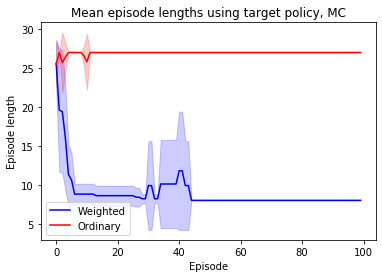

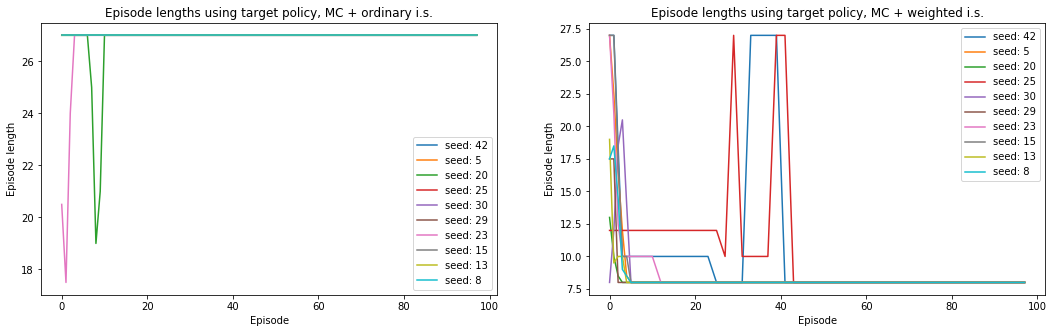

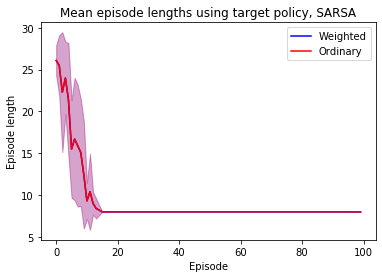

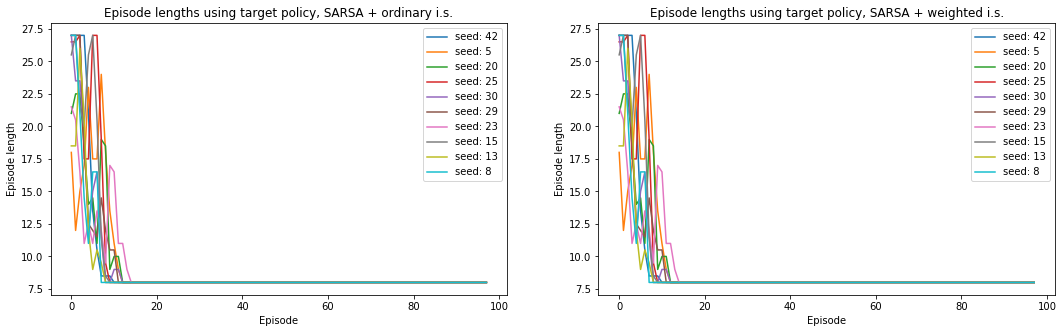

In [215]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

def plot_general_performance_all_seeds(weighted_model_stats, ordinary_model_stats, seeds, model='XX', average=False):

    if average:
        n = 1
        
        w_ep_lens = np.array(weighted_model_stats[3])
        o_ep_lens = np.array(ordinary_model_stats[3])        

        w_ep_lens_mean = np.mean(w_ep_lens, axis=0)
        o_ep_lens_mean = np.mean(o_ep_lens, axis=0)
        
        x = np.arange(0,w_ep_lens.shape[1])
        
        plt.plot(x, w_ep_lens_mean, c='blue', label='Weighted')
        plt.plot(x, o_ep_lens_mean, c='red', label='Ordinary')
        
        w_sd = np.std(w_ep_lens, axis=0)
        o_sd = np.std(o_ep_lens, axis=0)
        
        w_fill_low = w_ep_lens_mean - w_sd
        w_fill_high = w_ep_lens_mean + w_sd
        
        o_fill_low = o_ep_lens_mean - o_sd
        o_fill_high = o_ep_lens_mean + o_sd        
        
        plt.fill_between(x, w_fill_low, w_fill_high, alpha=0.2, color='blue')
        plt.fill_between(x, o_fill_low, o_fill_high, alpha=0.2, color='red')
        
        plt.xlabel('Episode')
        plt.ylabel('Episode length')
        
        plt.title(f'Mean episode lengths using target policy, {model}')
        plt.legend()
        plt.show()
        
    else:
        # smoothing factor:
        n = 2
        w_ep_lens = weighted_model_stats[3]
        o_ep_lens = ordinary_model_stats[3]
        
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))
        
        for i, seed in enumerate(seeds):
            ax1.plot(running_mean(o_ep_lens[i],n), label=f"seed: {seed}")
            ax2.plot(running_mean(w_ep_lens[i],n), label=f"seed: {seed}")
            
        ax1.set_title(f'Episode lengths using target policy, {model} + ordinary i.s.')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Episode length')
        ax2.set_title(f'Episode lengths using target policy, {model} + weighted i.s.')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Episode length')
        ax1.legend()
        ax2.legend()
        
        plt.show()

### MC
plot_general_performance_all_seeds(mc_weighted_stats, mc_ordinary_stats, seeds, model='MC', average=True)
plot_general_performance_all_seeds(mc_weighted_stats, mc_ordinary_stats, seeds, model='MC', average=False)

### SARSA
plot_general_performance_all_seeds(sarsa_weighted_stats, sarsa_ordinary_stats, seeds, model='SARSA', average=True)
plot_general_performance_all_seeds(sarsa_weighted_stats, sarsa_ordinary_stats, seeds, model='SARSA', average=False)


## Variance

In [147]:
def plot_values_over_time(ordinary_list_of_dicts, weighted_list_of_dicts, seeds):
    
    n_seeds = len(seeds)
    n_states = len(ordinary_list_of_dicts[0])
    n_episodes = 100
    
    fig, axs = plt.subplots(n_states,2, figsize=(15,20))
    lspace = np.arange(0,n_episodes)

    for i in range(len(ordinary_list_of_dicts)):
        for j, (k,vals) in enumerate(ordinary_list_of_dicts[i].items()):
            axs[j,0].plot(lspace, vals, label=f"seed {i}")
            axs[j,1].plot(lspace, weighted_list_of_dicts[i][k], label=f"seed {i}")
            
    for j in range(n_states):
        state_names = list(ordinary_list_of_dicts[0].keys())
        axs[j,0].legend()
        axs[j,0].set_title(f"Q-values over episodes ordinary sampling, (state,action)={state_names[j]}")
        axs[j,1].legend()
        axs[j,1].set_title(f"Q-values over episodes weighted sampling, (state,action)={state_names[j]}")


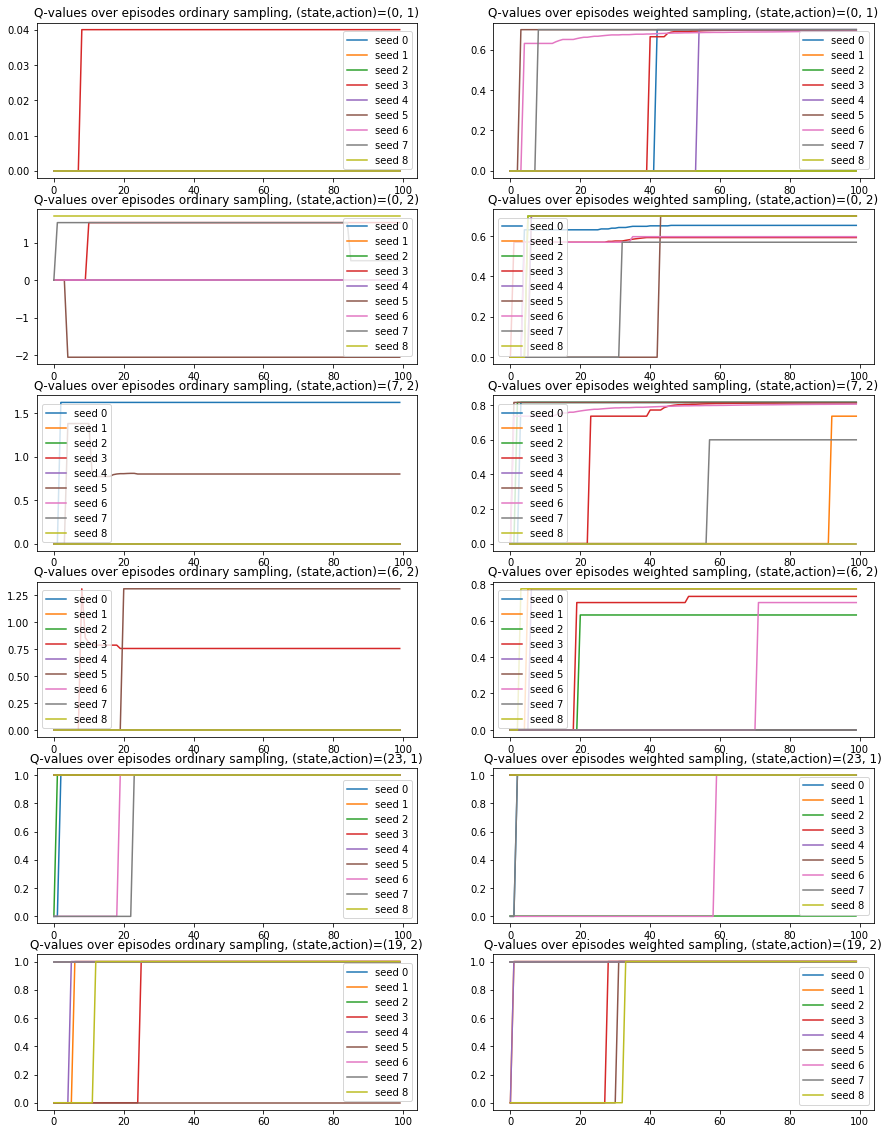

In [148]:
plot_values_over_time(mc_ordinary_stats[2], mc_weighted_stats[2], seeds)

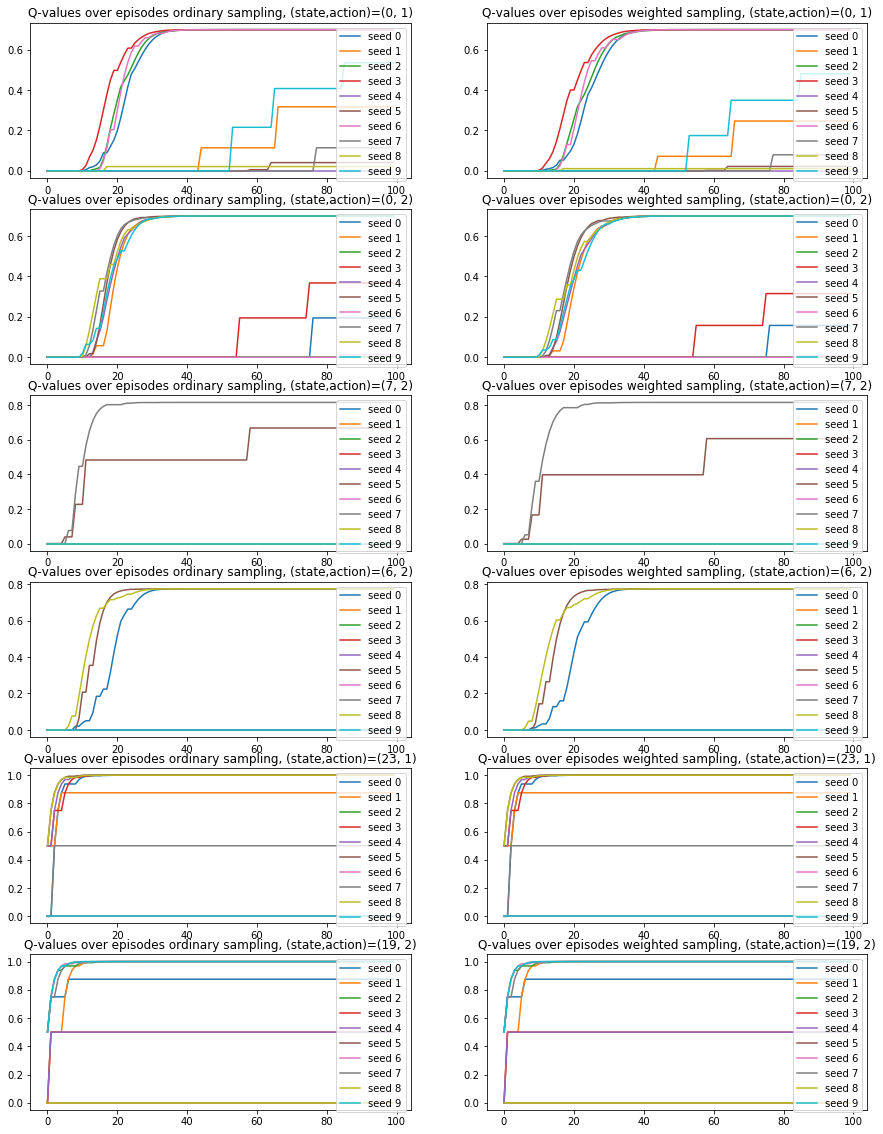

In [216]:
plot_values_over_time(sarsa_ordinary_stats[2], sarsa_weighted_stats[2], seeds)